# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import firestore
import json
import base64
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score



# **Loading the dataset**

In [ ]:
data=pd.read_csv('/content/Book1.csv', encoding='latin-1')
data.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results
0,2-Feb-24,M,34m,"nyalenda ,Nyalenda B ,Kisumu Central ,Kisumu",Acute upper respiratory infection (no pneumonia),Malaria blood smear,"plasmodium-species, result","Not applicable, Negative"
1,2-Feb-24,F,20,"AHERO ,Ahero ,Nyando ,Kisumu",Dental caries,,,
2,2-Feb-24,M,18m,"MANYATA ,Manyatta B ,Kisumu East ,Kisumu","Diarrhoea (Mild Dehydration), Diarrhoea (No De...",Malaria blood smear,"plasmodium-species, result","Not applicable, Negative"
3,2-Feb-24,M,21,"KMTC,LAKE VICTORIA ,Market Milimani ,Kisumu Ce...","Malaria (suspected), Sepsis without septic shock","Random blood glucose, Malaria blood smear, Com...",,
4,2-Feb-24,M,25m,"Mamboleo ,Kajulu ,Kisumu East ,Kisumu",Immunisation: Malaria,,,


# **Data Exploration**

In [ ]:
data.shape

(6767, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6767 entries, 0 to 6766
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Visit date                  6767 non-null   object
 1   Gender                      6767 non-null   object
 2   Age                         6767 non-null   object
 3   Location/Ward/Village       6767 non-null   object
 4   Diagnoses                   6767 non-null   object
 5   Investigation titles        6767 non-null   object
 6   Investigation tests         6767 non-null   object
 7   Investigation test results  6766 non-null   object
dtypes: object(8)
memory usage: 423.1+ KB


In [ ]:
data.describe()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results
count,6767,6767,6767,6767,6767,6767,6767,6766
unique,30,2,131,1732,2003,1223,831,3463
top,21-Feb-24,F,0m,"NYALENDA ,Market Milimani ,Kisumu Central ,Kisumu",,,,
freq,354,3839,273,315,1154,2539,3037,3036


# **Data Preprocessing**

## **Handling Missing Values**

In [ ]:
data.isnull().sum()

,0
Visit date,0
Gender,0
Age,0
Location/Ward/Village,0
Diagnoses,0
Investigation titles,0
Investigation tests,0
Investigation test results,1


In [ ]:
#dropping the missing value
data.dropna(inplace=True)
data.isnull().sum()

,0
Visit date,0
Gender,0
Age,0
Location/Ward/Village,0
Diagnoses,0
Investigation titles,0
Investigation tests,0
Investigation test results,0


## Handling Duplicates Values

In [ ]:
#checking for duplicate values
data.duplicated().sum()

np.int64(8)

In [ ]:
duplicate_rows = data[data.duplicated(keep=False)]

# Print the found duplicate rows.
if not duplicate_rows.empty:
    print("All instances of duplicate rows found in the dataset:")
    print(duplicate_rows.to_markdown(index=False, numalign='left', stralign='left'))
else:
    print("No exact duplicate rows were found.")


All instances of duplicate rows found in the dataset:
| Visit date   | Gender   | Age   | Location/Ward/Village                                          | Diagnoses                                                                                                                                                                                   | Investigation titles   | Investigation tests   | Investigation test results   |
|:-------------|:---------|:------|:---------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------|:----------------------|:-----------------------------|
| 7-Feb-24     | M        | 3m    | nyalenda ,Nyalenda A ,Kisumu East ,Kisumu                      | Immunisation: Rotavirus 1 vaccine, Immunisation: OPV 3 vaccine, Immunisation: DPT-HIB-HepB 3 vaccine, I

In [ ]:
#dropping the duplicates
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [ ]:
data.shape

(6758, 8)

In [ ]:
data.columns

Index(['Visit date', 'Gender', 'Age', 'Location/Ward/Village', 'Diagnoses',
       'Investigation titles', 'Investigation tests',
       'Investigation test results'],
      dtype='object')

### Handling Outliers

<Axes: >

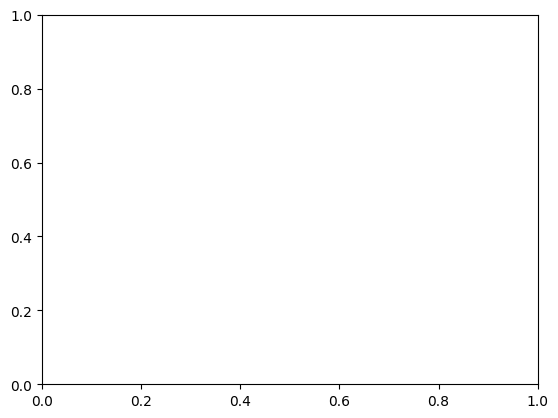

In [ ]:
#checking for outliers
sns.boxplot(data)

# Adding a new column for case priority

In [ ]:
try:
    df = pd.read_csv('/content/Book1.csv', encoding='latin-1')
    print("Data loaded successfully.")
    print("Original data (first 5 rows):")
    print(df.head())
except FileNotFoundError:
    print("Error: 'Book1.csv' not found. Please upload the file to your Colab session.")
    exit()

# --- Step 2: Define the Priority Rules ---
# We will create a dictionary that maps specific diagnoses to a priority level.
# This mapping is based on the diagnoses found in your Book1.csv file.
priority_mapping = {
    # High Priority Diagnoses (for severe or acute conditions)
    "Road Traffic Injury": "High Priority",
    "Sepsis without septic shock": "High Priority",
    "Oral cellulitis or abscess": "High Priority",
    "Sepsis": "High Priority", # Added for completeness

    # Medium Priority Diagnoses (for serious but typically not critical conditions)
    "Malaria (suspected)": "Medium Priority",
    "Diarrhoea (Mild Dehydration)": "Medium Priority",
    "Acute upper respiratory infection (no pneumonia)": "Medium Priority",

    # Low Priority Diagnoses (for routine or less severe conditions)
    "Dental caries": "Low Priority",
    "Immunisation: Malaria": "Low Priority",
    "superficial injury of the hand and forearm": "Low Priority",
    "Diarrhoea (No Dehydration)": "Low Priority",
}

# --- Step 3: Create the New 'Case Priority' Column ---
# This function assigns a priority based on the diagnoses.
def get_priority(diagnoses):
    # Handle cases where diagnoses is NaN or not a string
    if not isinstance(diagnoses, str):
        return "Unknown Priority"

    # Split diagnoses if there are multiple, e.g., "Malaria (suspected), Sepsis without septic shock"
    diagnoses_list = [d.strip() for d in diagnoses.split(',')]

    # Check for the highest priority first to handle multiple diagnoses correctly
    if any(priority_mapping.get(d) == "High Priority" for d in diagnoses_list):
        return "High Priority"
    if any(priority_mapping.get(d) == "Medium Priority" for d in diagnoses_list):
        return "Medium Priority"
    if any(priority_mapping.get(d) == "Low Priority" for d in diagnoses_list):
        return "Low Priority"

    return "Unknown Priority"

# Apply the function to the 'Diagnoses' column to create the new 'Case Priority' column
df['Case Priority'] = df['Diagnoses'].apply(get_priority)

# --- Step 4: Display the Result ---
print("\nData with new 'Case Priority' column (first 5 rows):")
print(df[['Diagnoses', 'Case Priority']].head())

print("\nValue counts of the new 'Case Priority' column:")
print(df['Case Priority'].value_counts())

Data loaded successfully.
Original data (first 5 rows):
  Visit date Gender  Age                              Location/Ward/Village  \
0   2-Feb-24      M  34m       nyalenda ,Nyalenda B ,Kisumu Central ,Kisumu   
1   2-Feb-24      F   20                       AHERO ,Ahero ,Nyando ,Kisumu   
2   2-Feb-24      M  18m           MANYATA ,Manyatta B ,Kisumu East ,Kisumu   
3   2-Feb-24      M   21  KMTC,LAKE VICTORIA ,Market Milimani ,Kisumu Ce...   
4   2-Feb-24      M  25m              Mamboleo ,Kajulu ,Kisumu East ,Kisumu   

                                           Diagnoses  \
0   Acute upper respiratory infection (no pneumonia)   
1                                      Dental caries   
2  Diarrhoea (Mild Dehydration), Diarrhoea (No De...   
3   Malaria (suspected), Sepsis without septic shock   
4                              Immunisation: Malaria   

                                Investigation titles  \
0                                Malaria blood smear   
1                   

In [ ]:
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2-Feb-24,M,34m,"nyalenda ,Nyalenda B ,Kisumu Central ,Kisumu",Acute upper respiratory infection (no pneumonia),Malaria blood smear,"plasmodium-species, result","Not applicable, Negative",Medium Priority
1,2-Feb-24,F,20,"AHERO ,Ahero ,Nyando ,Kisumu",Dental caries,,,,Low Priority
2,2-Feb-24,M,18m,"MANYATA ,Manyatta B ,Kisumu East ,Kisumu","Diarrhoea (Mild Dehydration), Diarrhoea (No De...",Malaria blood smear,"plasmodium-species, result","Not applicable, Negative",Medium Priority
3,2-Feb-24,M,21,"KMTC,LAKE VICTORIA ,Market Milimani ,Kisumu Ce...","Malaria (suspected), Sepsis without septic shock","Random blood glucose, Malaria blood smear, Com...",,,High Priority
4,2-Feb-24,M,25m,"Mamboleo ,Kajulu ,Kisumu East ,Kisumu",Immunisation: Malaria,,,,Low Priority


In [ ]:
df.columns

Index(['Visit date', 'Gender', 'Age', 'Location/Ward/Village', 'Diagnoses',
       'Investigation titles', 'Investigation tests',
       'Investigation test results', 'Case Priority'],
      dtype='object')

In [ ]:
# Save the updated DataFrame to a new CSV file
output_filename = 'Book1_with_priority.csv'
df.to_csv(output_filename, index=False)

print(f"Updated dataset saved to '{output_filename}'")

Updated dataset saved to 'Book1_with_priority.csv'


In [ ]:
# Check the distribution of the 'Case Priority' column
case_priority_distribution = df['Case Priority'].value_counts()

print("Distribution of 'Case Priority':")
print(case_priority_distribution)

Distribution of 'Case Priority':
Case Priority
Unknown Priority    4798
Medium Priority     1017
Low Priority         749
High Priority        203
Name: count, dtype: int64


## Encoding categorical Variables

In [50]:
#encoding categorical variables
from sklearn.preprocessing import LabelEncoder
Case_encoder = LabelEncoder()
df['Case Priority'] = Case_encoder.fit_transform(df['Case Priority'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [51]:
location_encoder = LabelEncoder()
df['Location/Ward/Village'] = location_encoder.fit_transform(df['Location/Ward/Village'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [52]:
Diagnoses_encoder = LabelEncoder()
df['Diagnoses'] = Diagnoses_encoder.fit_transform(df['Diagnoses'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [53]:
Titles_encoder = LabelEncoder()
df['Investigation titles'] = Titles_encoder.fit_transform(df['Investigation titles'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [54]:
Tests_encoder = LabelEncoder()
df['Investigation tests'] = Tests_encoder.fit_transform(df['Investigation tests'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [55]:
TestResults_encoder = LabelEncoder()
df['Investigation test results'] = TestResults_encoder.fit_transform(df['Investigation test results'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [56]:
Gender_encoder = LabelEncoder()
df['Gender'] = Gender_encoder.fit_transform(df['Gender'])
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


In [ ]:
#converting the age column to be in years only(Converting those in months)
def convert_age_to_years(age):
    if isinstance(age, str):
        if 'm' in age:
            # Assuming age with 'm' is in months, convert to years
            return int(age.replace('m', '')) / 12
        else:
            # Assuming age without 'm' is in years
            return int(age)
    # Handle cases where age is already a number or NaN if necessary
    return age

df['Age'] = df['Age'].apply(convert_age_to_years)
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2-Feb-24,1,2.833333,1532,76,421,483,3272,2
1,2-Feb-24,0,20.000000,5,413,0,0,1,1
2,2-Feb-24,1,1.500000,598,456,421,483,3272,2
3,2-Feb-24,1,21.000000,408,1208,645,0,1,0
4,2-Feb-24,1,2.083333,679,782,0,0,1,1


In [ ]:
#converting the visit date(monthname to string)
df['Visit date'] = pd.to_datetime(df['Visit date'], format='%d-%b-%y')
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


# Defining dependent and independent Variables

In [ ]:
#defining the dependent and independent variables
x = df.drop('Case Priority', axis=1)
y = df[['Case Priority']]

# Convert 'Visit date' to numerical timestamp
x['Visit date'] = x['Visit date'].astype('int64') // 10**9
df.head()

,Visit date,Gender,Age,Location/Ward/Village,Diagnoses,Investigation titles,Investigation tests,Investigation test results,Case Priority
0,2024-02-02,1,2.833333,1532,76,421,483,3272,2
1,2024-02-02,0,20.000000,5,413,0,0,1,1
2,2024-02-02,1,1.500000,598,456,421,483,3272,2
3,2024-02-02,1,21.000000,408,1208,645,0,1,0
4,2024-02-02,1,2.083333,679,782,0,0,1,1


# Splitting the Dataset

In [ ]:
#splitting the dataset into 70% training and 30% testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print("y_train as DataFrame shape:", y_train.shape)
print("y_test as DataFrame shape:", y_test.shape)
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)

y_train as DataFrame shape: (4736, 1)
y_test as DataFrame shape: (2031, 1)
x_train shape: (4736, 8)
x_test shape: (2031, 8)


# Training and Predicting Models

## Random Forest

In [ ]:

#training and Predicting random forest model
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
yr_pred=rf.predict(x_test)
yr_pred

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([3, 1, 3, ..., 3, 1, 3])

In [ ]:
#Evaluating the random forest using accuracy,precision,f1 score and recall
from sklearn.metrics import f1_score, recall_score, precision_score
accuracy = accuracy_score(y_test, yr_pred)
f1 = f1_score(y_test, yr_pred, average='weighted')
recall = recall_score(y_test, yr_pred, average='weighted')
precision = precision_score(y_test, yr_pred, average='weighted')

rf_results=pd.DataFrame(['Random Forest', accuracy, f1, recall, precision]).transpose()
rf_results.columns=['Model','Accuracy', 'F1 Score','Recall','Precision']
rf_results

,Model,Accuracy,F1 Score,Recall,Precision
0,Random Forest,0.913836,0.903474,0.913836,0.915358


## Decision Tree

In [ ]:
#training and predicting decision tree model
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_pred=dt.predict(x_test)
dt_pred

array([3, 1, 3, ..., 3, 1, 3])

In [ ]:
#evaluating decision tree
accuracy = accuracy_score(y_test, dt_pred)
f1 = f1_score(y_test, dt_pred, average='weighted')
recall = recall_score(y_test, dt_pred, average='weighted')
precision = precision_score(y_test, dt_pred, average='weighted')

dt_results=pd.DataFrame(['Decision Tree', accuracy, f1, recall, precision]).transpose()
dt_results.columns=['Model','Accuracy', 'F1 Score','Recall','Precision']
dt_results

,Model,Accuracy,F1 Score,Recall,Precision
0,Decision Tree,0.918759,0.919598,0.918759,0.920612


## Support Vector Machine

In [ ]:
#training and predicting SVM
from sklearn.svm import SVC
svm=SVC()
svm.fit(x_train,y_train)
svm_pred=svm.predict(x_test)
svm_pred


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 3, 3, ..., 3, 3, 3])

In [ ]:
#Evaluating svm
accuracy = accuracy_score(y_test, svm_pred)
f1 = f1_score(y_test, svm_pred, average='weighted')
recall = recall_score(y_test, svm_pred, average='weighted')
precision = precision_score(y_test, svm_pred, average='weighted')

svm_results=pd.DataFrame(['Support Vector Machine', accuracy, f1, recall, precision]).transpose()
svm_results.columns=['Model','Accuracy', 'F1 Score','Recall','Precision']
svm_results

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,F1 Score,Recall,Precision
0,Support Vector Machine,0.712949,0.593475,0.712949,0.508297


# Feature Importance

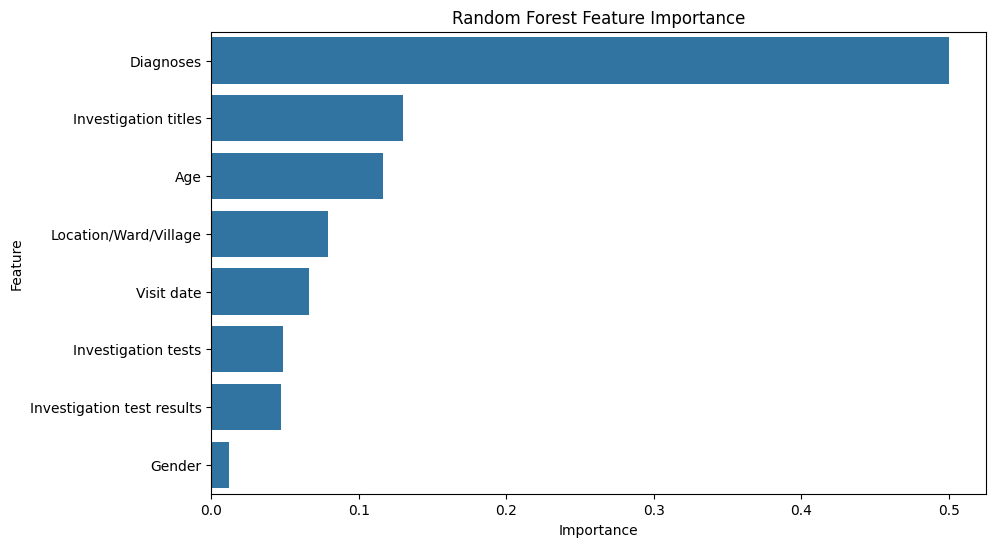

In [ ]:
#feature importance using random forest and plotting
feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()


# Model Deployment

In [ ]:
import pickle

In [48]:
import joblib

In [57]:
joblib.dump(Gender_encoder, 'Gender_encoder.pkl')

['Gender_encoder.pkl']

In [58]:
joblib.dump(location_encoder, 'location_encoder.pkl')

['location_encoder.pkl']

In [59]:
joblib.dump(Diagnoses_encoder, 'Diagnoses_encoder.pkl')

['Diagnoses_encoder.pkl']

In [60]:
joblib.dump(Titles_encoder, 'Titles_encoder.pkl')

['Titles_encoder.pkl']

In [61]:
joblib.dump(Tests_encoder, 'Tests_encoder.pkl')

['Tests_encoder.pkl']

In [62]:
joblib.dump(TestResults_encoder, 'TestResults_encoder.pkl')

['TestResults_encoder.pkl']

In [ ]:
filename = 'DecisionTree_model.pkl'
pickle.dump(dt, open(filename, 'wb'))

In [ ]:
filename = 'DecisionTree_model.pkl'
pickle.dump(dt, open(filename, 'wb'))

In [ ]:
# Create a new LabelEncoder specifically for the 'Case Priority' column
case_priority_label_encoder = LabelEncoder()

# Load the data again to access the original 'Case Priority' column before encoding
# Assuming the file "Book1_with_priority.csv" saved earlier contains the 'Case Priority' column with string labels.
try:
    df_original_priority = pd.read_csv('Book1_with_priority.csv')
    print("Data with original 'Case Priority' labels loaded successfully.")
except FileNotFoundError:
    print("Error: 'Book1_with_priority.csv' not found. Please run the cell to save the updated data first.")
    exit()


# Fit the encoder on the original string labels of the 'Case Priority' column
case_priority_label_encoder.fit(df_original_priority['Case Priority'])

print("Label encoder for 'Case Priority' fitted on original labels.")
# You can check the classes learned by the encoder:
print("Classes:", case_priority_label_encoder.classes_)

Data with original 'Case Priority' labels loaded successfully.
Label encoder for 'Case Priority' fitted on original labels.
Classes: ['High Priority' 'Low Priority' 'Medium Priority' 'Unknown Priority']


In [ ]:
# Example: predict for a new instance of Case Priority
# The input data should have the same features as the training data:
# 'Visit date', 'Gender', 'Age', 'Location/Ward/Village', 'Diagnoses',
# 'Investigation titles', 'Investigation tests', 'Investigation test results'
# All these features have been preprocessed into numerical format.

# Let's create a sample input data point. You'll need to provide values
# in the numerical format corresponding to your preprocessing steps.

# Example values (replace with actual values based on your data's encoding and scale):
# Visit date (numerical timestamp - example: a date in Feb 2024)
sample_visit_date = pd.to_datetime('2024-02-15').value // 10**9
# Gender (encoded: 0 for Female, 1 for Male)
sample_gender = 1 # Assuming Male
# Age (in years)
sample_age = 30.0
# Location/Ward/Village (encoded - example value)
sample_location = 598 # Replace with an actual encoded location value
# Diagnoses (encoded - example value)
sample_diagnoses = 76 # Replace with an actual encoded diagnoses value
# Investigation titles (encoded - example value)
sample_investigation_titles = 421 # Replace with an actual encoded value
# Investigation tests (encoded - example value)
sample_investigation_tests = 483 # Replace with an actual encoded value
# Investigation test results (encoded - example value)
sample_investigation_test_results = 3272 # Replace with an actual encoded value


# Combine the sample input data into a list in the correct order of features
input_data = [
    sample_visit_date,
    sample_gender,
    sample_age,
    sample_location,
    sample_diagnoses,
    sample_investigation_titles,
    sample_investigation_tests,
    sample_investigation_test_results
]

# Changing the input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array as we are predicting for a single instance
input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

# Make the prediction using the trained Decision Tree model (dt)
prediction_encoded = dt.predict(input_data_reshaped)

# Print the predicted case priority (the output is the encoded priority)
print('Predicted Case Priority (encoded): {}'.format(prediction_encoded[0]))

# To get the actual case priority name, you would need the inverse mapping from the label encoder used for the 'Case Priority' column.
# Assuming you still have the 'label_encoder' object used for encoding the 'Case Priority' column (from cell WU000nwGLtLP):
# You might need to re-fit the label encoder on the original 'Case Priority' column from the df DataFrame
# to ensure it has the complete mapping if the original was overwritten or not stored.
# For demonstration, assuming the label_encoder object from cell WU000nwGLtLP is still available and contains the mapping:
try:
    # Use the new case_priority_label_encoder for inverse transform
    predicted_priority_label = case_priority_label_encoder.inverse_transform(prediction_encoded)
    print('Predicted Case Priority: {}'.format(predicted_priority_label[0]))
except NameError:
    print("Could not inverse transform: 'case_priority_label_encoder' not found.")
    print("Please run the cell to create and fit 'case_priority_label_encoder'.")
except ValueError as e:
    print(f"Error during inverse transform: {e}")
    print("This might happen if the encoder was not fitted on all possible predicted labels.")

Predicted Case Priority (encoded): 2
Predicted Case Priority: Medium Priority


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st
import pandas as pd
import datetime
from google.cloud import firestore
import json
import base64
import os
from gtts import gTTS
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here
import numpy as np # Import numpy here
import joblib # Import joblib here
import uuid

In [ ]:
!pip install gTTS

In [64]:
%%writefile app.py
# --- 1. Load Machine Learning Model and Label Encoders ---
loaded_model = None
# Dictionary to hold all label encoders
label_encoders = {}
try:
    # We will assume a single model file is trained on the full dataset with the new 'Case Priority' labels
    model_path = '/content/DecisionTree_model.pkl'
    loaded_model = joblib.load(model_path)

    # We will also assume the encoder for 'Diagnoses' is saved separately
    diagnoses_encoder_path = '/content/Diagnoses_encoder.pkl'
    label_encoders['Diagnoses'] = joblib.load(diagnoses_encoder_path)

    st.success("Machine learning model and label encoders loaded successfully. ✅")
except FileNotFoundError:
    st.error("Error: Ensure model and encoder files are present in the same directory. Please run the training script first. ❌")
except Exception as e:
    st.error(f"Error loading ML assets: {e} ⚠️")

# --- 2. Prediction Function ---
def predict_priority(diagnoses_text):
    if loaded_model is None or 'Diagnoses' not in label_encoders:
        return "Model or encoder not available"

    try:
        # Transform the diagnoses text into the format the model expects
        diagnoses_encoded = label_encoders['Diagnoses'].transform([diagnoses_text])

        # Reshape the array for the model
        input_data_reshaped = np.asarray(diagnoses_encoded).reshape(1, -1)

        # Make the numerical prediction
        numerical_prediction = loaded_model.predict(input_data_reshaped)[0]

        # We need a reverse mapping for the priority levels.
        # This mapping should be defined in your training script.
        # Let's assume the numerical values map to:
        # 0: 'High Priority', 1: 'Medium Priority', 2: 'Low Priority'
        priority_mapping_reverse = {0: 'High Priority', 1: 'Medium Priority', 2: 'Low Priority'}

        predicted_priority = priority_mapping_reverse.get(numerical_prediction, "Unknown Priority")

        return predicted_priority
    except Exception as e:
        st.error(f"An error occurred during prediction: {e} 😞")
        return "Prediction error"

# --- 3. Main Streamlit App Function ---
def main():
    st.set_page_config(page_title="Intelligent Dispatch Dashboard", layout="wide")

    st.title("🚑 Intelligent Dispatch Dashboard")
    st.markdown("---")

    # Use session state to store and manage the list of requests
    if 'requests' not in st.session_state:
        st.session_state.requests = []

    # --- Incoming Requests Section ---
    st.header("1. Incoming Requests")
    with st.expander("Submit a New Request"):
        with st.form("new_request_form", clear_on_submit=True):
            col1, col2 = st.columns(2)
            with col1:
                patient_name = st.text_input("Patient Name")
            with col2:
                patient_age = st.number_input("Patient Age", min_value=0, max_value=120)

            patient_location = st.text_input("Patient Location/Ward/Village")

            # Use the diagnoses from the original data as options
            diagnoses_options = list(Diagnoses_encoder.classes_)
            patient_diagnosis = st.selectbox("Diagnoses", diagnoses_options)

            submitted = st.form_submit_button("Submit Request")

            if submitted:
                # Use the ML model to predict priority
                priority = predict_priority(patient_diagnosis)

                # Check for prediction errors before adding the request
                if "Error" in priority or "Unknown" in priority or "not available" in priority:
                    st.error("Could not predict priority for this diagnosis. Please check model and encoder files.")
                else:
                    new_request = {
                        "id": str(uuid.uuid4()), # Generate a unique ID
                        "patient_name": patient_name,
                        "patient_age": patient_age,
                        "patient_location": patient_location,
                        "patient_diagnosis": patient_diagnosis,
                        "priority": priority,
                        "status": "Pending"
                    }
                    st.session_state.requests.append(new_request)
                    st.success(f"Request for {patient_name} submitted successfully with '{priority}' priority! 🌟")

    st.markdown("---")

    # --- Live Dispatch Board Section ---
    st.header("2. Live Dispatch Board")
    if not st.session_state.requests:
        st.info("No active requests. The dispatch board is clear. 😌")
    else:
        # Sort requests by priority: High -> Medium -> Low
        priority_order = {"High Priority": 0, "Medium Priority": 1, "Low Priority": 2}
        sorted_requests = sorted(st.session_state.requests, key=lambda x: priority_order.get(x['priority'], 3))

        for request in sorted_requests:
            # Use columns to create a clean layout
            col1, col2, col3, col4, col5 = st.columns([1, 1, 2, 1, 1])

            # Display patient name and diagnosis
            with col1:
                st.subheader(request['patient_name'])
                st.write(f"Age: {request['patient_age']}")
            with col2:
                st.write(f"**Diagnosis:**")
                st.write(request['patient_diagnosis'])

            with col3:
                st.write(f"**Priority:**")
                # Use a different color or icon for each priority level
                if request['priority'] == "High Priority":
                    st.error(request['priority'], icon="🚨")
                elif request['priority'] == "Medium Priority":
                    st.warning(request['priority'], icon="⚠️")
                else:
                    st.success(request['priority'], icon="✅")

            with col4:
                st.write(f"**Status:**")
                st.write(request['status'])

            with col5:
                # Buttons for status updates
                if request['status'] == "Pending":
                    if st.button("Dispatch", key=f"dispatch_{request['id']}"):
                        request['status'] = "Dispatched"
                        st.rerun()
                elif request['status'] == "Dispatched":
                    if st.button("Complete", key=f"complete_{request['id']}"):
                        request['status'] = "Completed"
                        st.rerun()

            st.markdown("---")

# Run the main function
if __name__ == '__main__':
    main()

Writing app.py


In [65]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [66]:
%pip install pyngrok -q

In [67]:
%pip install streamlit -q

In [68]:
from pyngrok import ngrok
import subprocess
import os
import time

# Terminate open tunnels if any
print("Terminate existing tunnels")
ngrok.kill()
time.sleep(2) # Give it a moment to terminate


# Set authtoken.
# Get yours from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "31ri6pWwFeoa1HgBmwjaN5fiJPa_7RKmZHrt1TdZSwH1XvmTV" # Replace with your actual ngrok authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


# Open a ngrok tunnel to the streamlit port 8501
# <NgrokTunnel: "http://<public_subdomain>.ngrok.io" -> "http://localhost:8501">
print("Opening ngrok tunnel")
public_url = ngrok.connect(addr='8501')

print(f"Streamlit app available at: {public_url}")

Terminate existing tunnels
Opening ngrok tunnel
Streamlit app available at: NgrokTunnel: "https://b56277872127.ngrok-free.app" -> "http://localhost:8501"
